In [36]:
%matplotlib inline
from qiskit.visualization import plot_histogram
from qiskit import QuantumCircuit
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit.transpiler import generate_preset_pass_manager
from qiskit.visualization import plot_histogram
import math

In [7]:
#Classical Search

In [8]:
myList = [5,4,6,9,1,2,3,7,8,0]

In [9]:
def oracle(number):
    winningNumber = 8
    if number == winningNumber:
        response = True
    else:
        response = False
    return response

In [10]:
for index, number in enumerate(myList):
    if oracle(number) is True:
        print(f"winning number index: {index}")
        print(f"execution count: {index+1}")
        break

winning number index: 8
execution count: 9


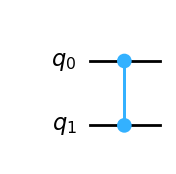

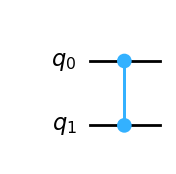

In [11]:
#Quantum Model with Grover's Algorithm
#Oracle Circuit (WinningNumber = 11)

oracleCircuit = QuantumCircuit(2,name='oracleCircuit')
oracleCircuit.cz(0,1)
oracleCircuit.to_gate()
oracleCircuit.draw(output='mpl')

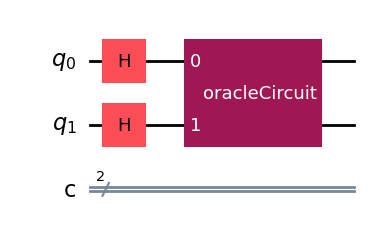

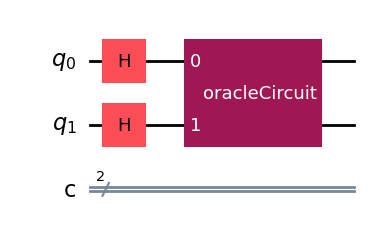

In [12]:
mainCircuit = QuantumCircuit(2,2)
mainCircuit.h([0,1])
mainCircuit.append(oracleCircuit,[0,1])
mainCircuit.draw(output='mpl')

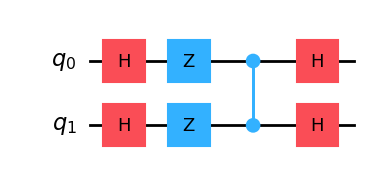

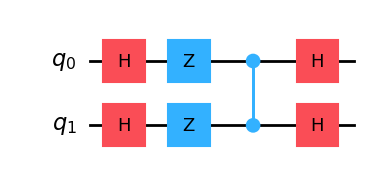

In [13]:
reflectionCircuit = QuantumCircuit(2,name="reflectionCircuit")
reflectionCircuit.h([0,1])
reflectionCircuit.z([0,1])
reflectionCircuit.cz(0,1)
reflectionCircuit.h([0,1])
reflectionCircuit.to_gate()
reflectionCircuit.draw(output='mpl')

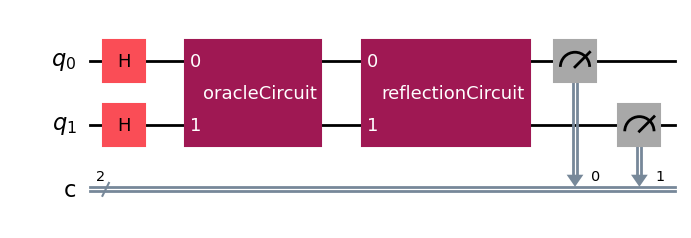

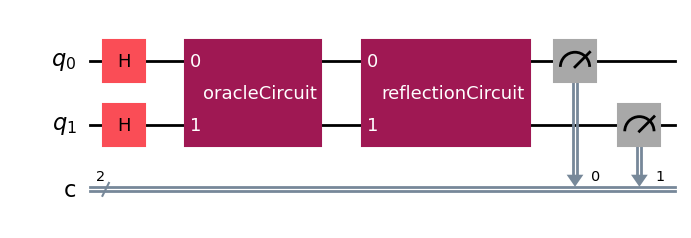

In [14]:
mainCircuit.append(reflectionCircuit,[0,1])
mainCircuit.measure([0,1],[0,1])
mainCircuit.draw(output='mpl')

In [15]:
service = QiskitRuntimeService()
backend = service.least_busy(simulator=False, operational=True)

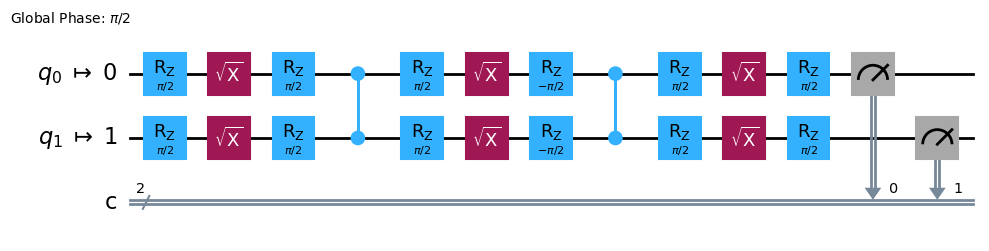

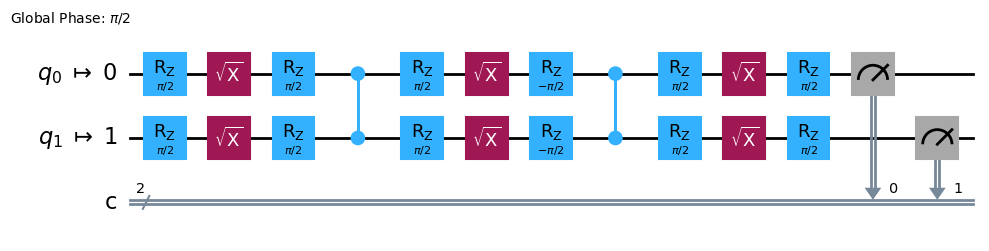

In [16]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(mainCircuit)
 
isa_circuit.draw("mpl", idle_wires=False)

In [17]:
sampler = Sampler(mode=backend)
jobSampler = sampler.run([isa_circuit], shots=100)
result = jobSampler.result()
counts = result[0].data.c.get_counts()
print(counts)

{'10': 20, '11': 63, '01': 10, '00': 7}


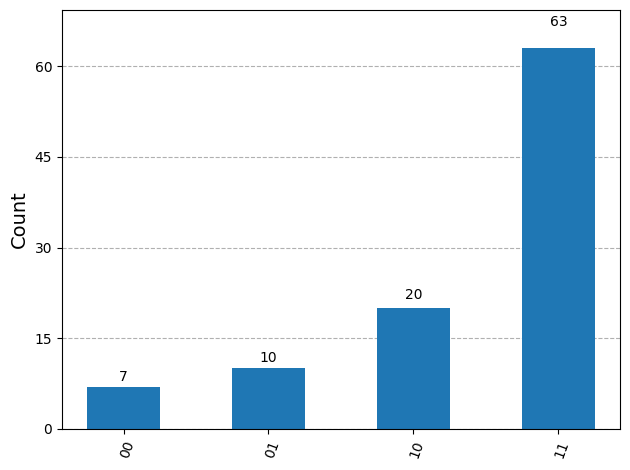

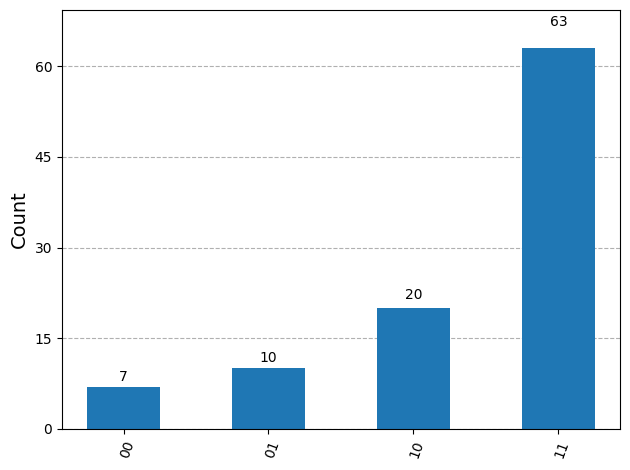

In [18]:
plot_histogram(counts)

In [46]:
def buildOracleCircuit(target:str) -> QuantumCircuit:
    n = len(target)
    oracleCircuit = QuantumCircuit(n,name=f'    0racle_{target}')

    # Apply X gates to qubits corresponding to '0's in the target bitstring
    zeros = [i for i, bit in enumerate(reversed(target)) if bit == '0']
    if zeros:
        oracleCircuit.x(zeros)

    # Apply multi-controlled Z gate
    target = n-1
    controls = list(range(n-1))
    oracleCircuit.h(target)
    oracleCircuit.mcx(controls,target)
    oracleCircuit.h(target)

    # Apply X gates again to revert the earlier transformation
    if zeros:
        oracleCircuit.x(zeros)

    return oracleCircuit.to_gate()

In [47]:
def buildReflectionCircuit(n:int) -> QuantumCircuit:
    reflectionCircuit = QuantumCircuit(n,name=f"    reflection_{n}")

    # Apply Hadamard and X gates to all qubits
    reflectionCircuit.h(range(n))
    reflectionCircuit.x(range(n))

    # Apply multi-controlled Z gate
    target = n-1
    controls = list(range(n-1))
    reflectionCircuit.h(target)
    reflectionCircuit.mcx(controls,target)
    reflectionCircuit.h(target)

    # Apply X and Hadamard gates again to revert the earlier transformation
    reflectionCircuit.x(range(n))
    reflectionCircuit.h(range(n))

    return reflectionCircuit.to_gate()

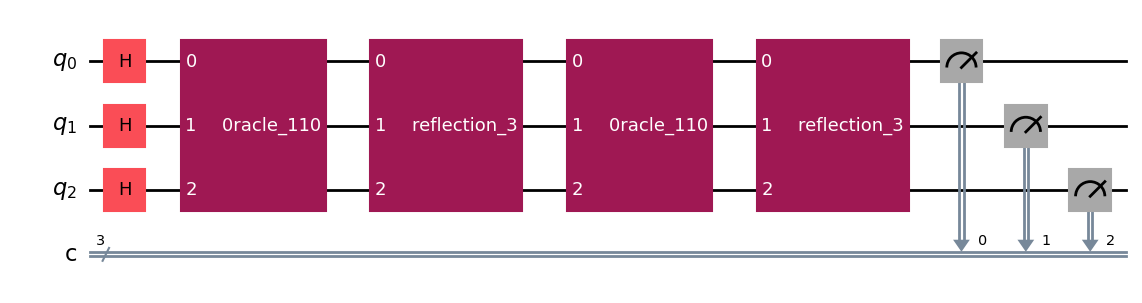

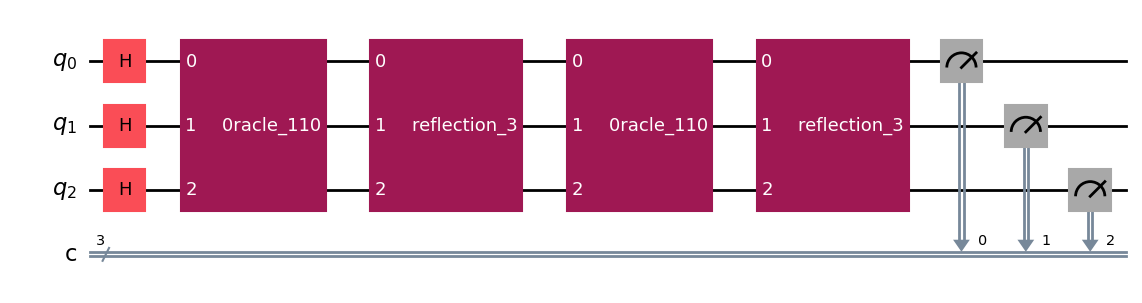

In [ ]:
# our list [5,4,6,9,1,2,3,7,8,0]
# target 8 is in index 6
# which is 110 in binary

target = '110'
n = len(target)
mainCircuit = QuantumCircuit(n,n)
mainCircuit.h(range(n))
oracleGate = buildOracleCircuit(target)
reflectionGate = buildReflectionCircuit(n)

# Calculate number of iterations which is approximately pi/4 * sqrt(2^n/M), n=number of qubits, M=number of solutions(1 here)
iterations = math.pi / 4 * (2**(n/2))
for _ in range(round(iterations)):
    mainCircuit.append(oracleGate, range(n))
    mainCircuit.append(reflectionGate, range(n))

mainCircuit.measure(range(n), range(n))
mainCircuit.draw(output='mpl')

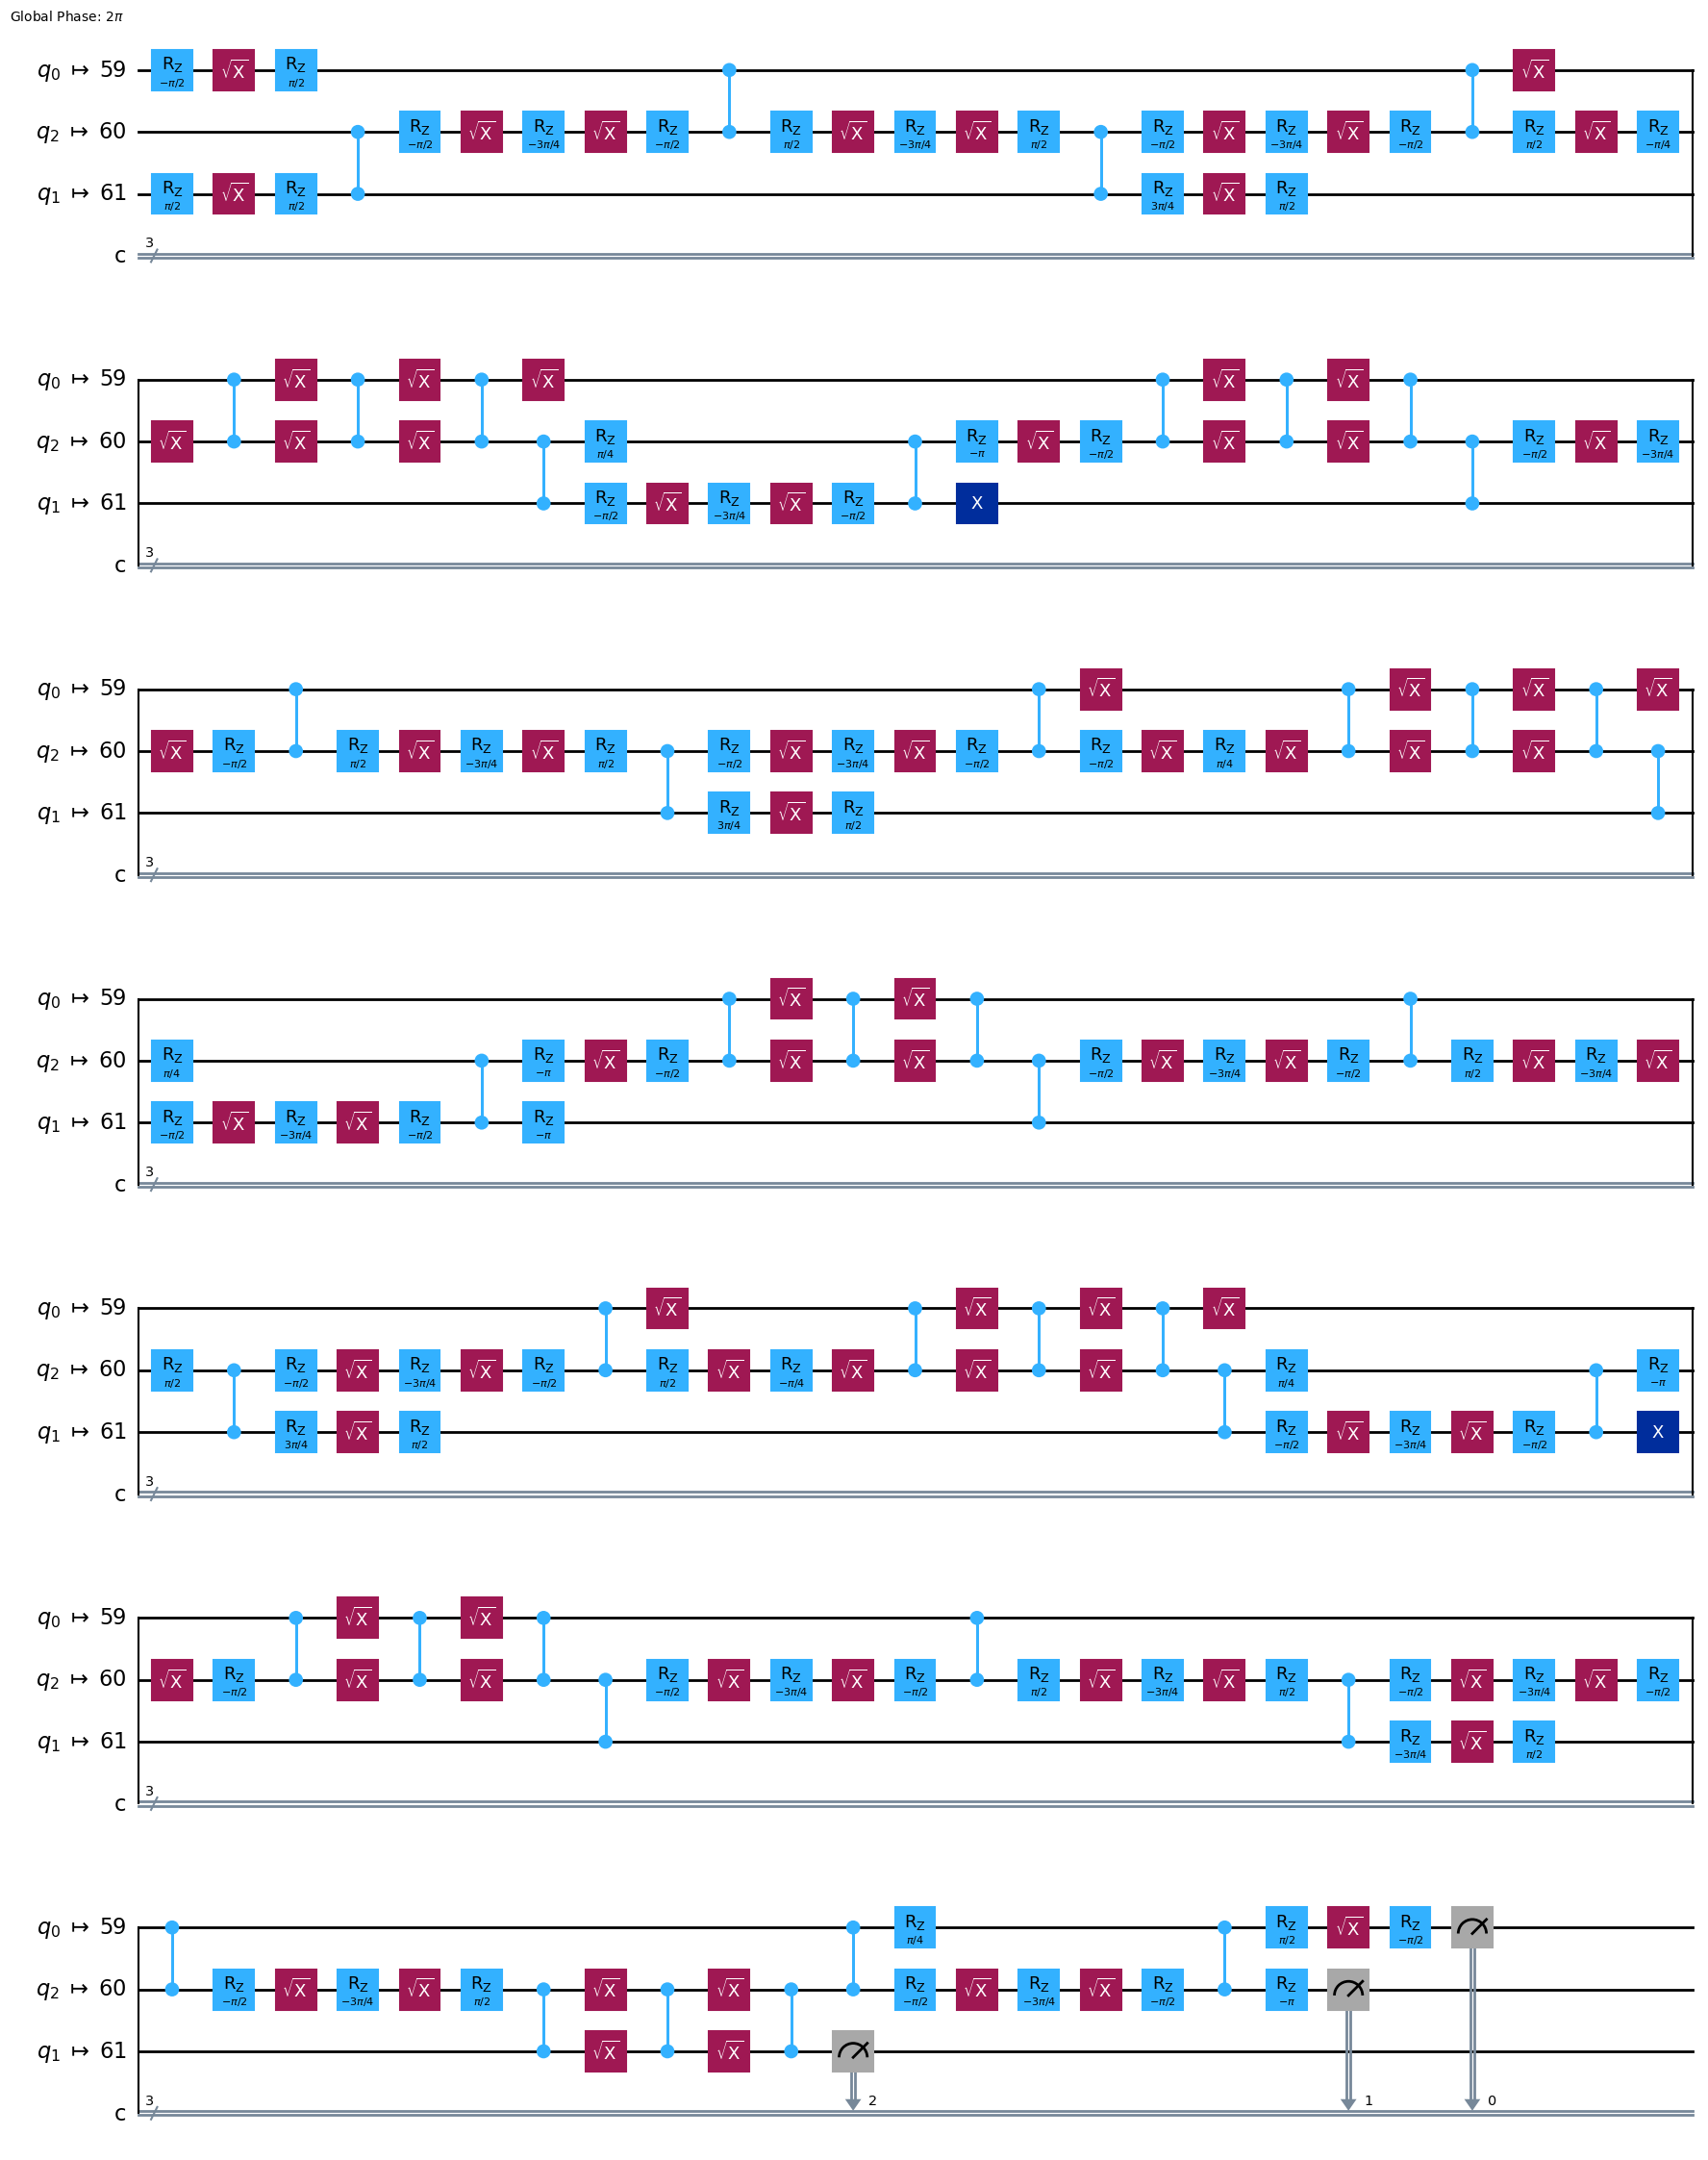

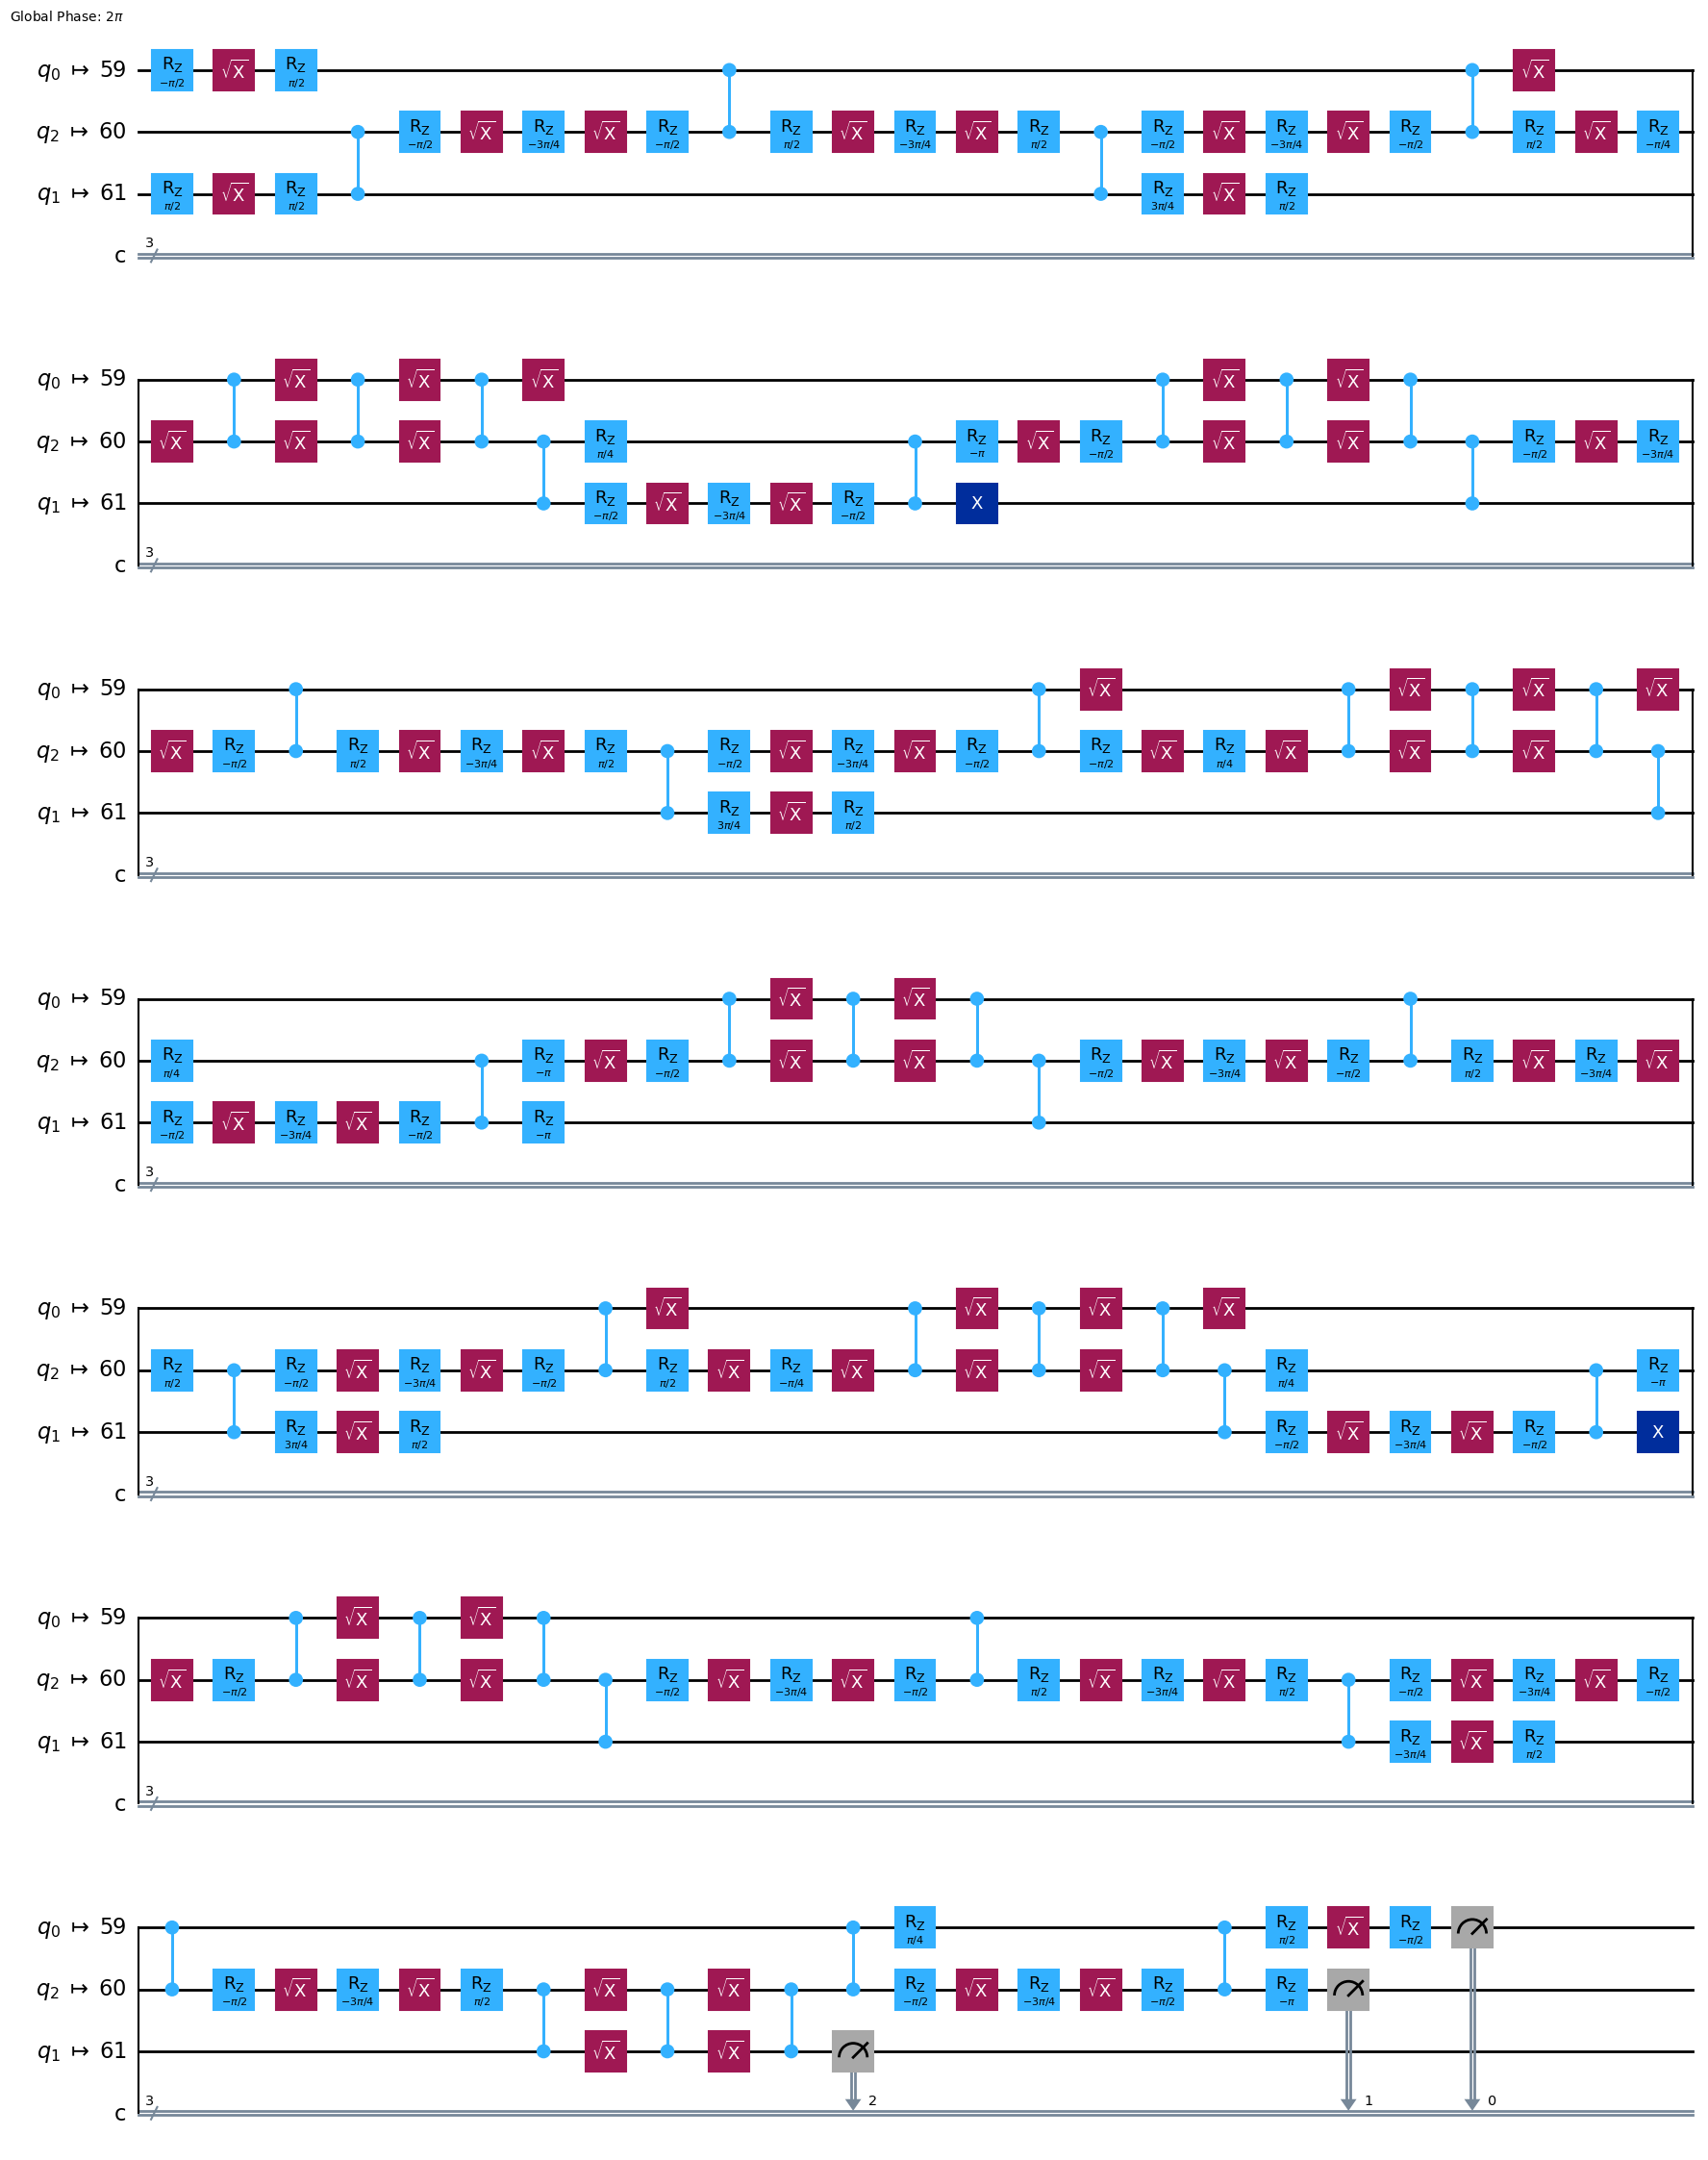

In [50]:
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)
isa_circuit = pm.run(mainCircuit)
 
isa_circuit.draw("mpl", idle_wires=False)

In [51]:
sampler = Sampler(mode=backend)
jobSampler = sampler.run([isa_circuit], shots=100)
result = jobSampler.result()
counts = result[0].data.c.get_counts()
print(counts)

{'110': 73, '011': 6, '100': 6, '010': 6, '111': 3, '001': 3, '101': 1, '000': 2}


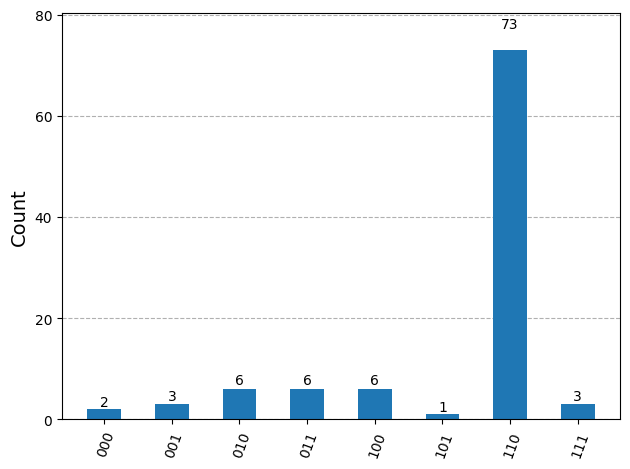

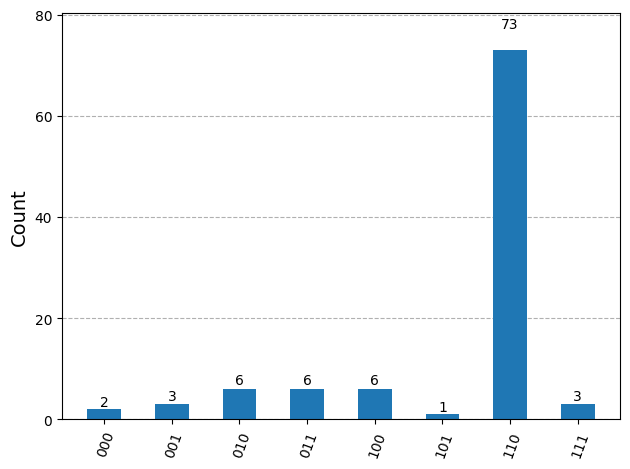

In [52]:
plot_histogram(counts)